# Authorship Detection (Working Script)

In [1]:
## load required packages and set global conditions
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import re
import nltk
import spacy
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import plot_confusion_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter 
import pickle

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
## load spacy
nlp = spacy.load("en_core_web_sm", parser = False)

In [3]:
## load the current list of prefixes & remove # from the list 
## (keep hastags in tact)
prefixes = list(nlp.Defaults.prefixes)
prefixes.remove('#')

## recompile a new prefix regex with the smaller list of prefixes
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
## set the tokenizer prefix_search to use the search of the newly compiled regex
nlp.tokenizer.prefix_search = prefix_regex.search

In [4]:
## set colors for prettier prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Define Functions for Load, Reformatting, and Basic Summarization Tasks

In [5]:
def dataImport(file):
    '''
    Imports the data
    Inputs: file (str)
    Outputs: DF (Pandas DF)
    '''
    #import the dataset
    DF = pd.read_csv(file)
    
    return DF

In [6]:
def summaryStats(DF):
    '''
    Generate Summmary Statitics for the full feature space
    Input: DF (pd DF)
    Output: None
    '''
    
    print('\n###########', 'Summary Statistics', '###########\n')
    print('Dataframe Structure:', DF.shape)

    print('\nVariable Types:')
    print(DF.dtypes)
    
    print('\nSummary Stats (Quantitative Features)')
    print(DF.describe())
    
    print('\nSummary Stats (Qualitative Features)')
    print(DF.describe(include=['object']))

In [7]:
def reformatData(DF):
    '''
    Restructure the data as required (change column names, dtypes, etc) 
    Input: DF (pd DF)
    Output: textDF (pd DF)
    '''
    #rename the columns
    DF.columns = ['Datetime', 'TweetID','FullText', 'Truncated', 'RepliedTo',
                  'GeoTagged', 'Coordinates', 'Location', 'RetweetCount', 
                  'FavoriteCount', 'Sensitive?', 'Lang', 'UserName', 'UserLocation',
                  'UserDescription', 'UserFollowers', 'UserFriends', 'UserStatusCount']
    
    #convert the columns to the appropriate data types
    DF['Datetime']= pd.to_datetime(DF['Datetime']) 
    
    #convert remaining columns to the appropriate type
    DF = DF.astype({'Sensitive?': bool, 'TweetID': str})
    
    #only focused on the text data so only retain columns of interest for
    #textual analysis
    textDF = DF[['Datetime', 'TweetID', 'FullText', 'UserName', 'Lang']]
        
    return textDF

In [8]:
def scoreData(DF):
    '''
    Score the dataframe to ensure that each feature is in the appropriate value range
    and/or has no NA
    Input: DF (pd DF)
    Output: None
    '''
    ##check datetime range
    bad_date = 0
    
    #check date range (June 1, 2019 to Super Tuesday 2020)
    for date in DF['Datetime']:
        if date < datetime(2019, 6, 1, 0, 0, 0, 0, pytz.UTC) or \
            date > datetime(2020, 3, 3, 0, 0, 0, 0, pytz.UTC):
            bad_date += 1
    
    #check for null values
    bad_date += sum(DF['Datetime'].isnull())
    
    #TweetID should be unique
    bad_id = len(DF['TweetID'])-len(DF['TweetID'].drop_duplicates())
    bad_id += sum(DF['TweetID'].isnull())
    
    #FullText cannot be empty
    bad_text = sum(DF['FullText'].isnull()) 
    
    #UserName
    names = ['Amy Klobuchar', 'Bernie Sanders', 'Elizabeth Warren', 'Joe Biden',
             'Pete Buttigieg', 'Tom Steyer', 'Tulsi Gabbard 🌺']
    
    bad_names = 0
    
    for name in DF['UserName']:
        if name not in names:
            bad_names += 1
     
    ## check if the language is not english            
    bad_lang = 0
    
    for language in DF['Lang']:
        if language != 'en':
            bad_lang += 1
    
    ## generate the score
    print('\n######## Data Frame Score by Column #########')   
    print("Date Column: ", bad_date)
    print("TweetID Column: ", bad_id)
    print("Text Column: ", bad_text)
    print("UserNames Column:", bad_names)
    print("Language Column (not English):", bad_lang)
    
    bad_total = bad_date + bad_id + bad_text + bad_names + bad_lang
    score = bad_total / (DF.shape[0]*DF.shape[1])
    
    print('\n######## Total DF Score #########')   
    print('Total DF Cleanliness Score:', 100-round(score * 100, 2))

In [9]:
def cleanData(DF):
    '''
    Clean the dataset by dropping duplicate tweets and removing those that 
    are not in english
    Input: DF (pd DF)
    Output: DF (pd DF)
    '''
    #drop columns with duplicate tweet ID
    DF = DF.drop_duplicates('TweetID', keep = 'last')

    #drop tweets that are not in English    
    DF = DF[DF['Lang'] == 'en']
    
    return DF

In [10]:
def keepChars(tweet):
    '''
    Cleans an invididual tweet by removing non-character features, any url link, 
    etc. Designed to be used with a map function.
    Input: tweet (list of tokens)
    Output: charTweet (list of tokens)
    '''
    ## initialize a list to store the characters only
    charTweet = []
    
    ## do I want to filter NER before I begin?????
    
    for token in tweet:
        ## remove token if it contains a url link
        if 'http' in token.text:
            continue
        
        ## remove a token if it contains a mention, hastag, punctuation, etc.
        elif re.match(r'[^0-9a-zA-Z_]', token.text):
            continue
        
        ## remove token if it is less than one character long
        elif len(token.text) < 2:
            continue
        
        ## append the new token to the character only token list
        else:
            charTweet.append(token)
        
    return charTweet

#### _Load and Understand the Data_

In [11]:
DF = dataImport('Data/DemTweetsReformat.csv')
DF.head(2)

,created_at,id,full_text,truncated,in_reply_to_screen_name,geo,coordinates,place,retweet_count,favorite_count,possibly_sensitive,lang,user.name,user.location,user.description,user.followers_count,user.friends_count,user.statuses_count
0,Mon Mar 02 01:07:24 +0000 2020,1234284135386095616,"John Lewis leading marchers across the Edmund Pettus Bridge in Selma in 1965. What an honor to see him there today, fighting cancer but his voice just as strong. https://t.co/UMp7Snao7T",False,NaN,NaN,NaN,NaN,599,4156,False,en,Amy Klobuchar,NaN,U.S. Senator from Minnesota. Text AMY to 91990 for updates.,1066377,137980,11782
1,Mon Mar 02 00:56:17 +0000 2020,1234281337776955392,Pete Buttigieg has run an inspiring and historic campaign. I have so much respect for you @PeteButtigieg and know there are great things ahead. And both John and I are big fans of Chasten!,False,NaN,NaN,NaN,NaN,5019,89534,NaN,en,Amy Klobuchar,NaN,U.S. Senator from Minnesota. Text AMY to 91990 for updates.,1066377,137980,11782


In [12]:
## get the number of tweets by user
print(DF['user.name'].value_counts())

Elizabeth Warren    2347
Joe Biden           2183
Amy Klobuchar       2017
Tom Steyer          1990
Bernie Sanders      1861
Pete Buttigieg      1700
Tulsi Gabbard 🌺     1085
Name: user.name, dtype: int64


In [13]:
## generate basic summary statistics
summaryStats(DF)


########### Summary Statistics ###########

Dataframe Structure: (13183, 18)

Variable Types:
created_at                  object
id                           int64
full_text                   object
truncated                     bool
in_reply_to_screen_name     object
geo                        float64
coordinates                float64
place                      float64
retweet_count                int64
favorite_count               int64
possibly_sensitive          object
lang                        object
user.name                   object
user.location               object
user.description            object
user.followers_count         int64
user.friends_count           int64
user.statuses_count          int64
dtype: object

Summary Stats (Quantitative Features)
                 id  geo  coordinates  place  retweet_count  favorite_count  \
count  1.318300e+04  0.0          0.0    0.0   13183.000000    13183.000000   
mean   1.196794e+18  NaN          NaN    NaN    1385.434499     

In [14]:
## reformat the dataframe--removing unneeded column
## modifying data types, etc.
DF = reformatData(DF)

In [15]:
## get a preliminary score for the dataset cleanliness
scoreData(DF)


######## Data Frame Score by Column #########
Date Column:  0
TweetID Column:  138
Text Column:  0
UserNames Column: 0
Language Column (not English): 257

######## Total DF Score #########
Total DF Cleanliness Score: 99.4


In [16]:
## clean the data
DF = cleanData(DF)

## rescore the data
scoreData(DF)


######## Data Frame Score by Column #########
Date Column:  0
TweetID Column:  0
Text Column:  0
UserNames Column: 0
Language Column (not English): 0

######## Total DF Score #########
Total DF Cleanliness Score: 100.0


In [17]:
## tokenize every tweet in the dataframe & adding a new column in the process
DF['Tokens'] = DF['FullText'].apply(lambda x: nlp.tokenizer(x))
DF['TextOnly'] = DF['Tokens'].map(keepChars)

In [18]:
## confirm edits and final dataset structure
DF.head(2)

,Datetime,TweetID,FullText,UserName,Lang,Tokens,TextOnly
0,2020-03-02 01:07:24+00:00,1234284135386095616,"John Lewis leading marchers across the Edmund Pettus Bridge in Selma in 1965. What an honor to see him there today, fighting cancer but his voice just as strong. https://t.co/UMp7Snao7T",Amy Klobuchar,en,"(John, Lewis, leading, marchers, across, the, Edmund, Pettus, Bridge, in, Selma, in, 1965, ., , What, an, honor, to, see, him, there, today, ,, fighting, cancer, but, his, voice, just, as, strong, ., https://t.co/UMp7Snao7, T)","[John, Lewis, leading, marchers, across, the, Edmund, Pettus, Bridge, in, Selma, in, 1965, What, an, honor, to, see, him, there, today, fighting, cancer, but, his, voice, just, as, strong]"
1,2020-03-02 00:56:17+00:00,1234281337776955392,Pete Buttigieg has run an inspiring and historic campaign. I have so much respect for you @PeteButtigieg and know there are great things ahead. And both John and I are big fans of Chasten!,Amy Klobuchar,en,"(Pete, Buttigieg, has, run, an, inspiring, and, historic, campaign, ., , I, have, so, much, respect, for, you, @PeteButtigieg, and, know, there, are, great, things, ahead, ., And, both, John, and, I, are, big, fans, of, Chasten, !)","[Pete, Buttigieg, has, run, an, inspiring, and, historic, campaign, have, so, much, respect, for, you, and, know, there, are, great, things, ahead, And, both, John, and, are, big, fans, of, Chasten]"


### Exploratory Analysis #1: Mendenall Curve

In [19]:
def mendenhallAnalysis(nlp, DF):
    '''
    Generate Mendenhall's Curve to understand the stylometric differences
    between the candidate's tweeting styles
    Input: nlp (spaCy) and DF (pandas)
    Output: None
    '''
    ## initialize a dictionary to store the results
    totalDict = {}
    
    ## for each candidate count the number of times that words of each
    ## word length are used
    for name in DF['UserName'].unique():
        text = DF[DF['UserName'] == name]['TextOnly']
        
        ## the candidate's word length dictionary
        candDict = {}
        
        ## for each tweet calculate the length of each word
        for tweet in text:
            for token in tweet:
                tokenLen = len(token)
                
                ## if that word length exists in the dictionary add one
                ## otherwise add a new value
                if tokenLen in candDict.keys():
                    candDict[tokenLen] += 1
                else:
                    candDict[tokenLen] = 0
        
        ## sum the candidate's total tokens (to generate relative value)
        sumTokens = sum(candDict.values())            
        
        ## generate the relative useage rate and sort by key (word length)
        totalDict[name] = {k: v/sumTokens for k, v in sorted(candDict.items(), key=lambda item: item[0], reverse = False)}
        
    ## generate mendenhall's curve
    fig, ax = plt.subplots(figsize = (12,8))

    for cand in totalDict.keys():
        ## if the candidate's word length range was relatively unique
        ## assign a random color and associate it with their name
        ## otherwise color their curve grey and give the generic 'Other Candidate Label'
        if totalDict[cand][3] > .22:
            ax.plot(totalDict[cand].keys(), totalDict[cand].values(), label = cand)
        elif totalDict[cand][4] < .17:
            ax.plot(totalDict[cand].keys(), totalDict[cand].values(), label = cand)
        else:
            try:
                i
            except:
                i = 0
            ax.plot(totalDict[cand].keys(), totalDict[cand].values(), color = '#D3D3D3',
                    alpha = .6, label = 'Other Candidates' if i == 0 else '')
            i += 1
    
    ## clean the plot and its formatting
    ax.set_xlim(2, 15)    
    ax.set_ylim(0, .24)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Word Length')
    ax.set_ylabel('Percent of Total Words')
    ax.set_yticklabels(["{:.0%}".format(i) for i in ax.get_yticks()])
    ax.set_title("Candidate Word Length Tendancies: Mendenhall's Characteristic Curve", 
                 loc = 'left', fontweight = 'semibold', fontsize = 14)
    ax.legend(title = '$\\bf{Candidate}$', edgecolor = 'none')     

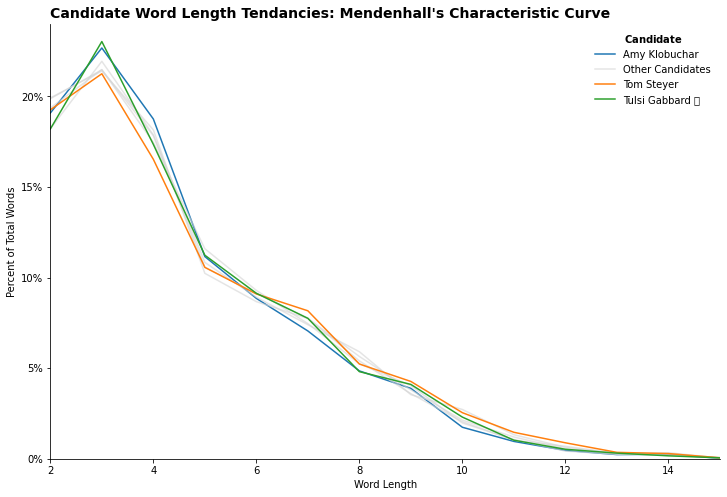

In [20]:
## build the Mendenhall Curve
mendenhallAnalysis(nlp, DF)

The analysis above is based on the work of literary scholar T.C. Mendenhall who theorized in 1887 that an author's stylistic signature could be determined by counting how often they used words of different lengths. While coarse by necessity of the time period in which he lived, the results of this analysis can be quickly generated and may provide some interesting insights (François Dominic Laramée, 2018). 

Studying Mendenhall’s Characteristic Curves of Composition, there appears to be little difference in terms of word-length usage between Democratic Presidential Candidates on Twitter. Tom Steyer (the orange curve)--a non-career politician--had the most distinct curve of the group as he tended to use larger words more frequently than the other canidates. Could this be a sign of his naiveness about what constitutes a successul social media campaign for a politician? Additionally, two of three woman candidates studied (Amy Klobuchar and Tulsi Gabbard) tended to use three-letter words much more frequently than their male-counterparts. This may be a signal a concerted effort by both campaigns to make their candidates relatable through simple and direct language. 

### Exploratory Analysis #1: Kilgariff's Chi-Squared Method

#### _Determine a Ideal Number of Common Words Shared by All Candidates_

In [21]:
def wordCounter(text):
    return Counter([w.lemma_.lower() for w in text])

In [22]:
## instatiate a counter object to store the results
totalCount = Counter()

## get the word count for each type in the corpus 
## and add that to the main counter object
for wDict in DF['Tokens'].map(wordCounter):
    totalCount += wDict

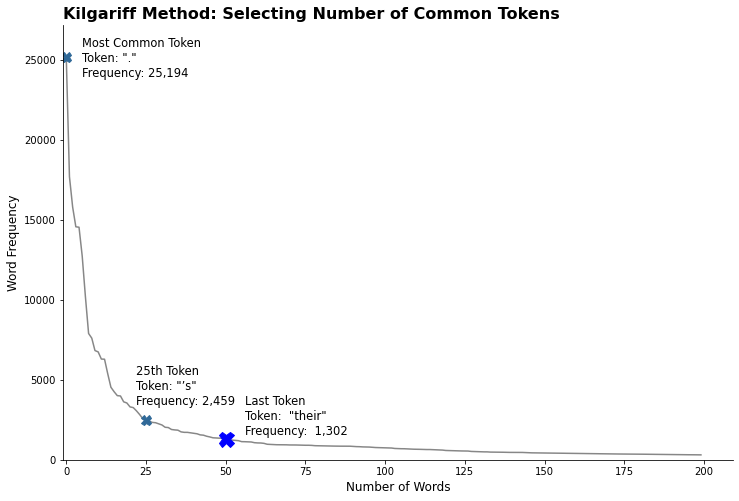

In [23]:
## sort the values and labels accordingly for better plotting
sortedCount = sorted(totalCount.values(), reverse = True)[:200]
sortedLabels = sorted(totalCount, key=totalCount.get, reverse = True) 

## visualize the results
fig, ax = plt.subplots(figsize = (12, 8))    
ax.plot(range(0, 200), sortedCount, color = '#878787')
ax.set_title('Kilgariff Method: Selecting Number of Common Tokens', 
            loc = 'left', fontsize = 16, fontweight = 'demi')

ax.plot(50, sortedCount[50],
        marker = 'X', markersize = 15, color = 'blue')
text = 'Last Token\nToken:  "{}"\nFrequency:  {:,}'.\
format(sortedLabels[50], sortedCount[50])
ax.annotate(text, xy = (50, sortedCount[50]),
           xytext = (56, sortedCount[50]+250),
           fontsize = 11.5)

ax.plot(0, sortedCount[0],
        marker = 'X', markersize = 10, color = '#306998')
text = 'Most Common Token\nToken: "{}"\nFrequency: {:,}'.\
format(sortedLabels[0], sortedCount[0])
ax.annotate(text, xy = (0, sortedCount[0]),
           xytext = (5, sortedCount[0]-1250),
           fontsize = 11.5)

ax.plot(25, sortedCount[25],
        marker = 'X', markersize = 10, color = '#306998')
text = '25th Token\nToken: "{}"\nFrequency: {:,}'.\
format(sortedLabels[25], sortedCount[25])
ax.annotate(text, xy = (25, sortedCount[25]),
           xytext = (22, sortedCount[25]+1000),
           fontsize = 11.5)

## clean the plot's formatting
ax.set_ylabel('Word Frequency', fontsize = 12)
ax.set_ylim(0,sortedCount[0]+2000)
ax.set_xlabel('Number of Words', fontsize = 12)
ax.set_xlim(-1,)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [24]:
## see the top 50 words
sortedLabels[19] = '-enter-' ##clean up the literal carriage returns

## print the header information
print(color.CYAN + color.BOLD)
print('##### WORD USE RANKING #####')
print('{:<13}{:<13}{:<13}{:<13}{:<13}'.format('1-10', '11-20', '21-30',
                                              '31-40', '41-50'))
print(color.END, end='')

## clean print the results
for i in range(0, 10):
    print(r'{:<13}{:<13}{:<13}{:<13}{:<13}'.format(sortedLabels[i], 
                                             sortedLabels[i+10],
                                             sortedLabels[i+20],
                                             sortedLabels[i+30],
                                             sortedLabels[i+40]))


##### WORD USE RANKING #####
1-10         11-20        21-30        31-40        41-50        
.            have         on           :            make         
the          for          you          trump        fight        
to           -pron-       —            people       at           
,            our          with         all          get          
be           that         it           president    work         
and          i            ’s           my           country      
a            this         do           who          us           
of           not          can          much         from         
in           will         !            need         by           
we           -enter-      -            american     go           


In [25]:
def kilgariffMethod(DF):
    '''
    Conduct's the Kilgariff Method of authorship analysis by looking
    at how each each author uses the most common words from the corpus
    writ large. The method of calculation relies upon the Chi-Square
    statistic to calculate the author's "distance" from the collective
    mean.
    
    Input: DF (pandas DF)
    Output: chiResults (dictionary)
    '''
    #### get total corpus word count ####
    ## instatiate a counter object to store the results
    totalCount = Counter()

    ## get the word count for each type in the corpus 
    ## and add that to the main counter object
    for wDict in DF['Tokens'].map(wordCounter):
        totalCount += wDict
        
    ## extract the most common 50 words
    totalCommon = totalCount.most_common()[0:50] 
    
    ## store the results of the chi-square test
    chiResults = {}
    
    ## calculate the chi-square value for each candidate's
    ## use of the top 100 words compared to the group norm
    for cand in DF['UserName'].unique():
        ## instatiate a counter for each candidate
        candCount = Counter()
        
        ## generate the word count breakdown for each candidate
        candDict = DF[DF['UserName'] == cand]['Tokens'].map(wordCounter)
        for wDict in candDict:
            candCount += wDict
        
        ##calcuate the canidate's total word count
        candTotal = sum(candCount.values())
        
        ## calculate the chi-square parameters
        actual = []      ## list to store the actual word useage
        expected = []    ## list to store the expected word useage
        
        ## calcuate the canidate's expected useage ratio
        candRatio = candTotal / sum(totalCount.values())
        for word, count in totalCommon:
            actual.append(candCount[word])
            expected.append(candRatio*count)

        ##calculate the chi-square value
        candChi = scipy.stats.chisquare(actual, expected)
        
        ## update the dictionary with each canidate's result
        chiResults[cand] = candChi
        
    return chiResults

In [26]:
## find similarities between tweeters and the whole corpus
chiResults =  kilgariffMethod(DF)

In [27]:
## clean print the results
cleanPrint = pd.DataFrame(chiResults).T
cleanPrint.columns = ['Distance', 'P-Value']
cleanPrint.drop('P-Value', axis = 1, inplace = True)
cleanPrint.sort_values('Distance', axis = 0, ascending = False)

,Distance
Elizabeth Warren,2735.180148
Bernie Sanders,2644.500605
Amy Klobuchar,1807.093963
Tulsi Gabbard 🌺,1579.565244
Joe Biden,1483.695022
Pete Buttigieg,812.529200
Tom Steyer,723.644876


Adam Kilgariff, in a 2001 paper, proposed using the chi-squared statistic to detemrmine authorship. According to his method the 'statistic' measurement is a given author's 'distance' from the average useage of a comparison corpus--whether it is a collective corpus, an unknown writing sample, etc. Therefore, the author with a smallest 'statistic' uses the most commonly occuring words (in this case the top 50 words) at a similar rate to the comparison documents (François Dominic Laramée, 2018).

Based on the results calculated above, stylitically, we can say that Tom Steyer and Pete Buttigieg have writing styles most similar to the collective whole while Elizabeth Warren and Bernie Sanders have writing styles that are very different from the rest of Democratic Presidential Candidates. Note, just because two canidates have a score close to each other does not mean that their writing styles are similiar, rather that their writing styles are equi-distant from the collective group average.

In [28]:
def kilgariffSpecial(train, test):
    '''
    A modified version of the previously explained Kilgariff Method
    to take a train and test dataset and to predict the author of the
    testing data. 
    Inputs: train (pandas DF), test (pandas DF)
    Output: bestCand (str)
    '''
    #### get unknown corpus word count ####
    ## instatiate a counter object to store the results
    totalCount = Counter()

    ## get the word count for each type in the corpus 
    ## and add that to the main counter object
    for wDict in test['Tokens'].map(wordCounter):
        totalCount += wDict

    ## extract the most common 50 words
    totalCommon = totalCount.most_common()[0:50] 

    ## store the results of the chi-square test
    chiResults = {}

    ## calculate the chi-square value for each candidate's
    ## use of the top 100 words compared to the group norm
    for cand in train['UserName'].unique():
        ## instatiate a counter for each candidate
        candCount = Counter()

        ## generate the word count breakdown for each candidate
        candDict = train[train['UserName'] == cand]['Tokens'].map(wordCounter)
        for wDict in candDict:
            candCount += wDict

        ##calcuate the canidate's total word count
        candTotal = sum(candCount.values())

        ## calculate the chi-square parameters
        actual = []      ## list to store the actual word useage
        expected = []    ## list to store the expected word useage

        ## calcuate the canidate's expected useage ratio
        candRatio = candTotal / sum(totalCount.values())
        for word, count in totalCommon:
            actual.append(candCount[word])
            expected.append(candRatio*count)

        ##calculate the chi-square value
        candChi = scipy.stats.chisquare(actual, expected)

        ## update the results dictionary
        chiResults[cand] = candChi
        
    ##### Assign Author #####
    ## initialize variables for authorship detection
    m = 500000          ## initialize chi-statistic
    bestCand = None     ## "best candidate"
    
    ## for each candidate and result, find the candidate whose
    ## style most closely matches that of the "test" tweets 
    for cand, result in chiResults.items():
        if result[0] < m and cand != 'Test':
            m = result[0]
            bestCand = cand

    return bestCand

In [29]:
def kilgariffHelper(n, train, test):
    '''
    A helper function to evaluate the optimal number of tweets
    required to accurately identify a candidate by their tweets.
    Due to a limited number of tweets for some canidates in the 
    testing dataset, 10 bootstrap samples are used to generate
    a sufficiently varied body of work for comparison.
    Input: train (pandas DF), test (pandas DF), n (int)
    Output: trueLabel (list), predLabel (list)
    '''
    ## initialize a dictionary to store algorithm results
    trueLabel = []
    predLabel = []

    ## for each candidate, take ten bootstrap samples of 50 tweets
    ## and pass those tweets to the kilgariff algorithm to assign
    ## a predicted author. Record results 
    for cand in test['UserName'].unique():
        for _ in range(0, 10):
            candSample = test[test['UserName'] == cand].sample(n)
            pred = kilgariffSpecial(train, candSample)
            trueLabel.append(cand)
            predLabel.append(pred)
    
    return trueLabel, predLabel

In [30]:
#### Identify the Number of Tweets Required to Accurately 
#### Predict a Candidate (TAKES 10+ MINUTES TO RUN)
## initialize a dictionary to store results
# kResults = {}

## run the Kilgariff Method for various number of unknown
## tweets recording the predicted labels & updating the dictionary
## accordingly
# for i in [1, 5, 10, 25, 50, 75, 100]:
#     ## Split Dataframe into training and testing
#     trainDF, testDF = train_test_split(DF, test_size = .2)    
#     iResults = kilgariffHelper(i, trainDF, testDF)
#     print('Iteration Num: ', i)
#     kResults[i] = iResults

## save the results for later use
# with open('kilgariffResults.pkl', 'wb') as file:
#     pickle.dump(kResults, file)

## load the previously recorded results
kResults = pickle.load(open('kilgariffResults.pkl', 'rb'))

In [31]:
## calcuate the F1-Score for each tweet-size iteration
## recording this result
fscores = []
for result in kResults.values():
    fscores.append(f1_score(result[0], result[1], average = 'macro'))

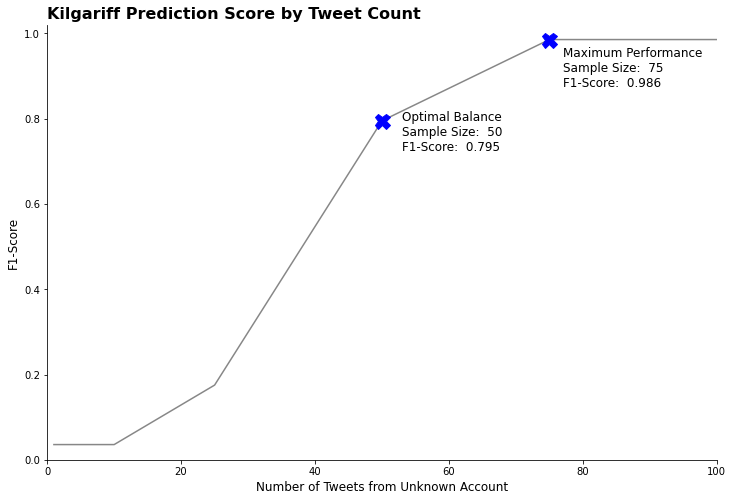

In [32]:
## visualize the results
## create the base plot
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(kResults.keys(), fscores, color = '#878787')
## add an annotation/marker for the optimal value
ax.plot(list(kResults.keys())[4], fscores[4], marker = 'X', 
        markersize = 15, color = 'blue')
text = 'Optimal Balance\nSample Size:  {}\nF1-Score:  {:.3f}'.\
format(str(list(kResults.keys())[4]), fscores[4])
ax.annotate(text, xy = (list(kResults.keys())[4], fscores[4]),
           xytext = (list(kResults.keys())[4]+3, fscores[4]-.07),
           fontsize = 12)
## add an annotation/marker for the maximum performace
ax.plot(list(kResults.keys())[5], fscores[5], marker = 'X', 
        markersize = 15, color = 'blue')
text = 'Maximum Performance\nSample Size:  {}\nF1-Score:  {:.3f}'.\
format(str(list(kResults.keys())[5]), fscores[5])
ax.annotate(text, xy = (list(kResults.keys())[5], fscores[5]),
           xytext = (list(kResults.keys())[5]+2, fscores[5]-.11),
           fontsize = 12)

ax.set_title('Kilgariff Prediction Score by Tweet Count', loc = 'left', 
             fontsize = 16, fontweight = 'demi')
ax.set_xlabel('Number of Tweets from Unknown Account', fontsize = 12)
ax.set_xlim(0, 100)
ax.set_ylabel('F1-Score', fontsize = 12)
ax.set_ylim(0, 1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [33]:
## View Detailed Results for Balanced Results
print(clsr(kResults[50][0], kResults[50][1]))

                  precision    recall  f1-score   support

   Amy Klobuchar       1.00      0.20      0.33        10
  Bernie Sanders       1.00      0.90      0.95        10
Elizabeth Warren       1.00      0.90      0.95        10
       Joe Biden       1.00      0.60      0.75        10
  Pete Buttigieg       1.00      1.00      1.00        10
      Tom Steyer       1.00      1.00      1.00        10
 Tulsi Gabbard 🌺       0.42      1.00      0.59        10

        accuracy                           0.80        70
       macro avg       0.92      0.80      0.80        70
    weighted avg       0.92      0.80      0.80        70



In [34]:
## View Detailed Results for Best Performance
print(clsr(kResults[75][0], kResults[75][1]))

                  precision    recall  f1-score   support

   Amy Klobuchar       1.00      1.00      1.00        10
  Bernie Sanders       1.00      1.00      1.00        10
Elizabeth Warren       1.00      1.00      1.00        10
       Joe Biden       1.00      1.00      1.00        10
  Pete Buttigieg       1.00      0.90      0.95        10
      Tom Steyer       1.00      1.00      1.00        10
 Tulsi Gabbard 🌺       0.91      1.00      0.95        10

        accuracy                           0.99        70
       macro avg       0.99      0.99      0.99        70
    weighted avg       0.99      0.99      0.99        70



This method shows a great deal of promise for authorship detection! Using just 75 tweets, an author could be detected from a field of seven candidates with greater than 99 percent accuracy. With just 50 tweets, the algorithm still runs well achieving nearly 80 percent accuracy. 

Specifically in related to this analysis, the model tended to over-attribute tweets to Tulsi Gabbard--something observed in the two cases printed above but was also observed during the construction of the algorithm as well. It seems that her writing style closely matches that of a few other candidates, especially Amy Klobuchar and Pete Buttigieg. 

### EDA #3: Visualize Canidate Tweets

In [35]:
def convertText(tokens):
    text = ''
    
    for token in tokens:
        text = text + ' ' + token.lemma_
        
    return text

In [36]:
def wordcloud(DF):
    '''
    Create a wordcloud for all tweets using the American flag as the 
    layout. This function generates the requisite strips and star field,
    which is then manually merged in a image editor.
    Input: DF (pandas DF)
    None
    '''
    #set the various name options, finalists, and other candidates
    names = DF['UserName'].unique()
    finalCand = ['Joe Biden', 'Bernie Sanders', 'Elizabeth Warren']
    otherCand = list(set(names)^set(finalCand))
    
    ## update the stopwords list
    stopwords = set(STOPWORDS)
    stopwords.update(['amp', 're', 'go', 'know', 'put', 'will', 'look', 'don', 
                      'll', 've', 'PRON', 'much'])
    
    ##### GENERATE THE STRIPES #####
    for name in names:
        ## final candidates get the longest stripes (set the width)
        if name in finalCand:
            width = 1500
        else:
            width = 1000
        ## create a temporary dataframe for the specific user
        temp = DF[DF['UserName'] == name]
        
        ## merge the candidates tweets into a single text body
#         text = ' '.join(' '.join(tokenList) for tokenList in temp['TextOnly'])
        text = ' '.join(temp['TextOnly'].map(convertText))
    
        ## generate the wordcloud
        wordcloud = WordCloud(stopwords = stopwords, 
                              background_color = 'white',
                              width = width, height = 70, 
                              max_words = 250, max_font_size = 75, 
                              min_font_size = 2, 
                              color_func=lambda *args, **kwargs: (178,34,52)).generate(text)        
        
        ## save the individual stripes
        filename = 'ANLY580_Project2_Authorship_' + name.split(' ')[1] + '.png'
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(filename, dpi = 300)
      
    ##### GENERATE THE BLUE FIELD #####
    ## convert the text to a single text field
    text = ' '.join(temp['TextOnly'].map(convertText))
    
    ## generate the word cloud
    wordcloud = WordCloud(stopwords = stopwords, background_color = 'white',
                              width = 700, height = 490, max_words = 550,
                              max_font_size = 175, min_font_size = 2, 
                              color_func=lambda *args, **kwargs: (60,59,110)).generate(text)
    
    plt.tight_layout(pad=0)  #removes white padding 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('ANLY580_Project2_Authorship_Stars.png', dpi = 300)
    plt.clf()

In [37]:
## generate the wordcloud
## (Don't rerun otherwise the random word assignments will be altered
## and will create a slighly different final product)
## wordcloud(DF)

![Something](ANLY580_Project2_Authorship_FlagNoBack.png)

The blue field in the wordcloud represents the total corpus, that is tweets from all candidates. The lemmatized tokens displayed therein are unsuprising given the nature of political messaging--that is candidates want to *thank* their supporters for their support of their *presidential* campaigns, talk about their efforts to improve the *country,* and build support for the *need* of their agenda. Interestingly, Tulsi Gabbard's name appears prominently in the collective word cloud, perhaps because her tweets include her name frequently which might be an attempt to increase her build her name recognition. Also, President Trump's name appears prominently, which may be an indicator that the Democratic Primary was less about the party and its ideals but more of an indictment of President Trump and his political agenda.

The individual candidate wordclouds (respresented by the red stripes) reveal the key political messages of each candidate. Can what stripe corresponds to which candidate? 

_"Red Stripe" Wordcloud Order (Top to Bottom): Mr. Tom Steyer, Rep. Tulsi Gabbard, Sen. Amy Klobuchar, Mayor Pete Buttigieg, Sen. Bernie Sanders, Sen. Elizabeth Warren, and V.P. Joe Biden._

What is clear from this analysis is that candidates such as Senators Bernie Sanders and Elizabeth Warren are "fighting" for major *structural change* on behalf of the *people.* Curiously, these two individuals used the token *American* less frequently than most other candidates. It is clear that a theme of President-Elect Biden's campaign was "Donald Trump" himself, likely because his platform was largely centered on being the only candidate capable of defeating the incumbant president. The messaging from other candidate's isn't as clear from this analysis, but some show a propensity to use Twitter as a launch pad for other campaign events as evidence by the word, *live* and *now* clearly displayed.

### Feature Generation (Castro & Lindauer Paper)

In [38]:
DF['NumTokens'] = DF['Tokens'].map(len)

In [39]:
def getAttributes(tweet):
    '''
    Get the tweet/text stylometric attributes for the given text
    Inputs: tweet (token)
    Outputs: chars (int), lowercase (float), uppercase (float),
             titlecase (float), nonascii (float), mentions (float),
            hashtags (float), link (float)
    '''
    ## initialize the various count variables
    chars = 0
    lowercase = 0
    uppercase = 0
    titlecase = 0
    nonascii = 0
    mentions = 0
    hashtags = 0
    link     = False
    
    ## for each token, count its labels and if it contains a desired 
    ## feature then add it to the respective variable
    for token in tweet:
        chars += len(token)
        
        if token.text.startswith('@'):
            mentions += 1
        elif token.text.startswith('#'):
            hashtags += 1
        elif token.like_url:
            link = True       
        else:
            if token.is_lower:
                lowercase += 1
            if token.is_upper:
                uppercase += 1
            elif token.is_title:
                titlecase += 1
            elif not token.is_ascii:
                nonascii += 1

    ## convert all to relative frequency
    lowercase = lowercase / len(tweet)
    uppercase = uppercase / len(tweet)
    titlecase = titlecase / len(tweet)
    nonascii  = nonascii / len(tweet)
    mentions  = mentions / len(tweet)
    hashtags  = hashtags / len(tweet)
  
    ## create the tuple to return
    returnList = (chars, lowercase, uppercase, titlecase, 
                  nonascii, mentions, hashtags, link)

    return returnList

In [40]:
## extract the attributes as specified by the castro-lindauer paper
castroAttributes = DF['Tokens'].map(getAttributes)

## convert to a dataframe for merging w/ original DF
attributeDF = pd.DataFrame(list(castroAttributes), 
                           columns=['NumChar','LowerFreq', 'UpperFreq',
                                    'TitleFreq', 'NonAscii', 'mentions',
                                    'hashtags', 'links'])    
DF.reset_index(inplace = True)

## merge the dataframes
featDF = DF.merge(attributeDF, left_index = True, right_index = True)

## confirm edits
featDF.head(2)

,index,Datetime,TweetID,FullText,UserName,Lang,Tokens,TextOnly,NumTokens,NumChar,LowerFreq,UpperFreq,TitleFreq,NonAscii,mentions,hashtags,links
0,0,2020-03-02 01:07:24+00:00,1234284135386095616,"John Lewis leading marchers across the Edmund Pettus Bridge in Selma in 1965. What an honor to see him there today, fighting cancer but his voice just as strong. https://t.co/UMp7Snao7T",Amy Klobuchar,en,"(John, Lewis, leading, marchers, across, the, Edmund, Pettus, Bridge, in, Selma, in, 1965, ., , What, an, honor, to, see, him, there, today, ,, fighting, cancer, but, his, voice, just, as, strong, ., https://t.co/UMp7Snao7, T)","[John, Lewis, leading, marchers, across, the, Edmund, Pettus, Bridge, in, Selma, in, 1965, What, an, honor, to, see, him, there, today, fighting, cancer, but, his, voice, just, as, strong]",35,157,0.600000,0.028571,0.200000,0.0,0.000000,0.0,True
1,1,2020-03-02 00:56:17+00:00,1234281337776955392,Pete Buttigieg has run an inspiring and historic campaign. I have so much respect for you @PeteButtigieg and know there are great things ahead. And both John and I are big fans of Chasten!,Amy Klobuchar,en,"(Pete, Buttigieg, has, run, an, inspiring, and, historic, campaign, ., , I, have, so, much, respect, for, you, @PeteButtigieg, and, know, there, are, great, things, ahead, ., And, both, John, and, I, are, big, fans, of, Chasten, !)","[Pete, Buttigieg, has, run, an, inspiring, and, historic, campaign, have, so, much, respect, for, you, and, know, there, are, great, things, ahead, And, both, John, and, are, big, fans, of, Chasten]",38,156,0.684211,0.052632,0.131579,0.0,0.026316,0.0,False


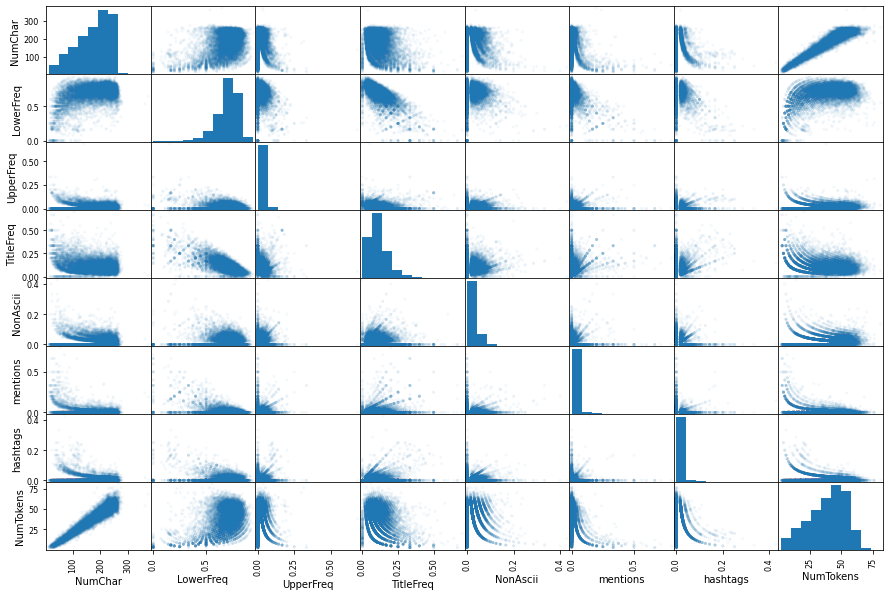

In [41]:
## check the newly created features for collinearity
p = pd.plotting.scatter_matrix(featDF[['NumChar','LowerFreq', 'UpperFreq',
                               'TitleFreq', 'NonAscii', 'mentions',
                               'hashtags', 'NumTokens']], alpha = .05,
                               figsize = (15, 10))

In [42]:
corMat = featDF[['NumChar','LowerFreq', 'UpperFreq',
                 'TitleFreq', 'NonAscii', 'mentions',
                  'hashtags', 'NumTokens']].corr()

## recolor to easier identify collinearity issues
corMat.style.applymap(lambda x: "background-color: #E52B50" if abs(x)>.5 else "background-color: #1F1F1F")

,NumChar,LowerFreq,UpperFreq,TitleFreq,NonAscii,mentions,hashtags,NumTokens
NumChar,1.000000,0.447267,-0.061633,-0.280276,-0.003411,-0.303149,-0.164354,0.946189
LowerFreq,0.447267,1.000000,-0.190098,-0.725185,-0.037868,-0.433502,-0.275466,0.443268
UpperFreq,-0.061633,-0.190098,1.000000,-0.113914,0.060323,0.052820,0.070664,-0.020974
TitleFreq,-0.280276,-0.725185,-0.113914,1.000000,-0.074293,0.117580,0.104449,-0.294962
NonAscii,-0.003411,-0.037868,0.060323,-0.074293,1.000000,-0.021263,-0.017561,0.049469
mentions,-0.303149,-0.433502,0.052820,0.117580,-0.021263,1.000000,-0.019777,-0.324316
hashtags,-0.164354,-0.275466,0.070664,0.104449,-0.017561,-0.019777,1.000000,-0.198293
NumTokens,0.946189,0.443268,-0.020974,-0.294962,0.049469,-0.324316,-0.198293,1.000000


Two feature sets have significant collinear relationships that need to be addressed prior to machine learning. The features representing titlecase frequency and lowercase frequency have a significant, negative collinear relationship while the character and token count features have a significant, positive relationship. Based on the results observed in the Catro and Lindauer paper, we will retain *NumTokens* and *LowerFreq* as they generated the greatest information gain during their research.

In [43]:
## metrics to eval
metrics = ['NumChar','LowerFreq', 'UpperFreq', 'TitleFreq',
           'NonAscii', 'mentions', 'hashtags']

for metric in metrics:
    print('\n##### Metric {} #####'.format(metric))
    temp = featDF.groupby(['UserName'])[metric].describe()
    print(temp[['mean', 'std']])



##### Metric NumChar #####
                        mean        std
UserName                               
Amy Klobuchar     176.727781  61.138039
Bernie Sanders    174.233950  56.859593
Elizabeth Warren  186.500430  55.047028
Joe Biden         179.252587  55.044758
Pete Buttigieg    179.222990  59.506233
Tom Steyer        155.079836  59.981178
Tulsi Gabbard 🌺   156.886294  85.046133

##### Metric LowerFreq #####
                      mean       std
UserName                            
Amy Klobuchar     0.640292  0.133821
Bernie Sanders    0.707286  0.107838
Elizabeth Warren  0.723091  0.097310
Joe Biden         0.708150  0.097950
Pete Buttigieg    0.712417  0.122345
Tom Steyer        0.691182  0.119860
Tulsi Gabbard 🌺   0.559273  0.215574

##### Metric UpperFreq #####
                      mean       std
UserName                            
Amy Klobuchar     0.022777  0.034625
Bernie Sanders    0.016091  0.026005
Elizabeth Warren  0.023267  0.026089
Joe Biden         0.016615  0.0242

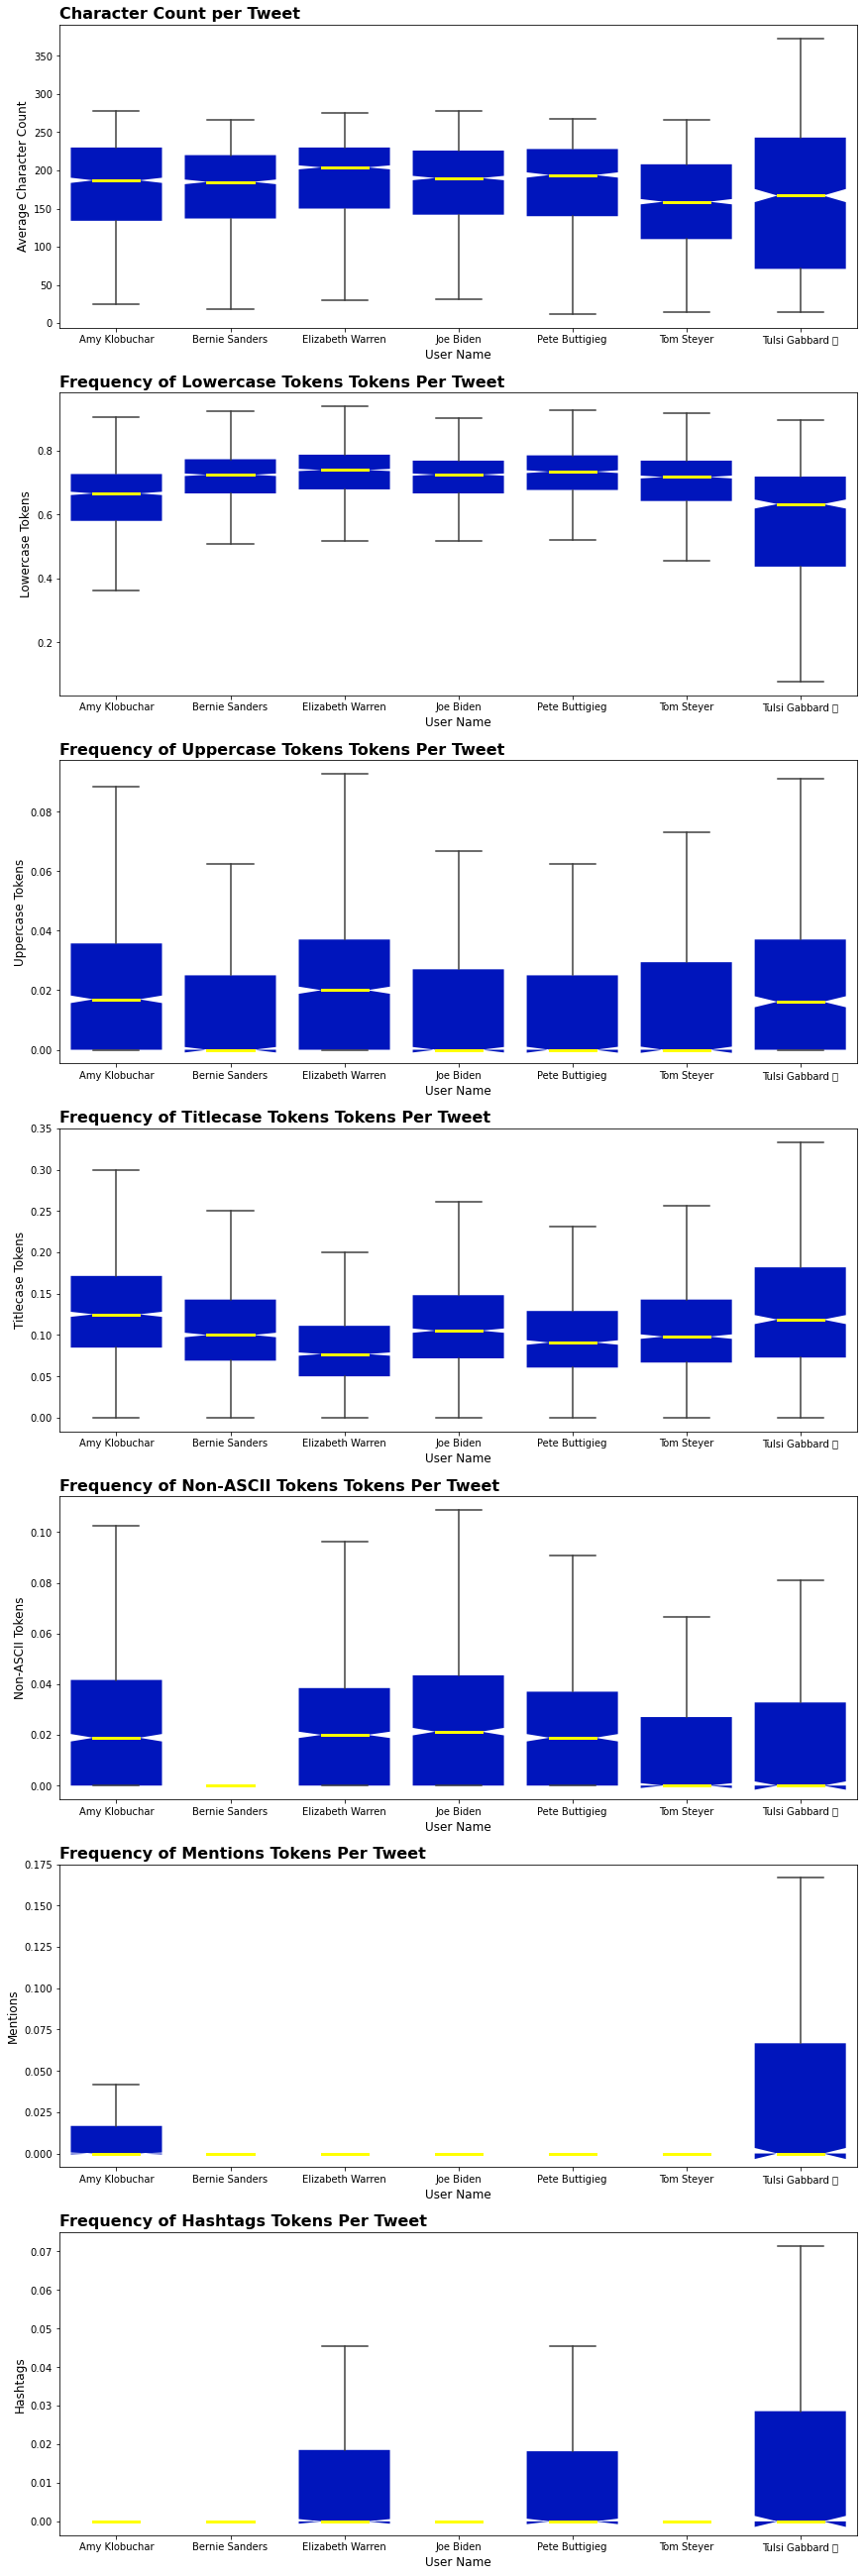

In [88]:
## construct the plot grid
fig, axes = plt.subplots(7, 1, constrained_layout = True, 
                        figsize = (12, 36))
## flatten the axes for easier additions
axes = axes.flat

## create clean titles for axis manipulation
cleanMetrics = ['Average Character Count', 'Lowercase Tokens',
              'Uppercase Tokens', 'Titlecase Tokens',
              'Non-ASCII Tokens', 'Mentions', 'Hashtags']

for i, metric, clean in zip(range(0, len(metrics)), metrics, cleanMetrics):
    ## set the axis for this plot
    ax = axes[i]
    ## generate the plot
    sns.boxplot(x = featDF['UserName'], y = featDF[metric],
                notch = True, medianprops = {'color':'yellow', 
                                            'linewidth':3}, 
                boxprops = {'linewidth':.5, 'color':'none',
                           'facecolor':'#0015BC'},
                showfliers = False,
                ax = ax)
    
    ## 'prettify' the charts
    ax.set_xlabel('User Name', fontsize = 12)
    
    ## set the y-axis and titles for each subplot
    if metric == 'NumChar':
        title = 'Character Count per Tweet'
        ax.set_title(title, loc = 'left', fontsize = 16, 
                     fontweight = 'semibold')
        ax.set_ylabel(clean, fontsize = 12)
        
    else:
        title = 'Frequency of ' + clean + ' Tokens Per Tweet'
        ax.set_title(title, loc = 'left', fontsize = 16, 
                     fontweight = 'semibold')
        ax.set_ylabel(clean, fontsize = 12)      
    

Significant differences exist between candidates in terms of their Twitter stylometry, particularly Congresswoman Tulsi Gabbard. Compared to the other canidates in the primary, her Twitter stylometry was wide-ranging with inconsistent tweet lengths and varied use of mentions and hashtags. This could be a sign of poor message standards amongst her public affairs team or a sign that congresswoman herself primarily tweeted from this account with many "off-the-cuff" remarks. Ironically, Congresswoman Gabbard had very little non-ASCII character (emoji) useage despite her username having one. Only Senator Sanders had a lower proportion of tokens that were non-ASCII characters (just 8 in 1000 tokens were emojis or similar tokens). Only three candidates used hashtags with any frequency--Mayor Pete Buttigieg, Congresswoman Tulsi Gabbard, and Senator Elizabeth Warren--while only Congresswoman Gabbard used mentions (**@**) with any real consistency, which seems somewhat counter-intuitive. Interestingly, all three female candidates tended to use all uppercase tokens (i.e. "NOT", "LIVE", "NOW") significantly more than their male counterparts. Is this a sign of aggressive rhetoric by candidates trying to stir support or is a stylometric difference between men and woman tweets writ large?

In [91]:
featDF.drop(['NumChar', 'TitleFreq'], axis = 1, inplace = True)

### Authorship Detection

#### Prepare the Pipeline

## Citations
François Dominic Laramée, "Introduction to stylometry with Python," The Programming Historian 7 (2018), https://doi.org/10.46430/phen0078.
Castro, Antonio, and Brian Lindauer. Author Identification on Twitter. http://cs229.stanford.edu/proj2012/CastroLindauer-AuthorIdentificationOnTwitter.pdf. Accessed 22 Oct. 2020.